## **Building a Classification Model for Predicting Risk of Mastistis in Cattle from Inexpensive Sensor Data.**

Prepared by Naeem Abdul Ghafoor


## 1. Import libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import figure
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

## 2. Load the data set

In [2]:
df = pd.read_csv("[RAW]clinical_mastitis_cows_input.csv") 
df

,Cow_ID,Breed,Months_after_giving_birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,Health
0,cow1,1,1,0,150,180,150,180,150,181,150,181,43,0,0,Healthy
1,cow1,1,1,0,152,180,152,185,151,180,152,181,42,0,0,Healthy
2,cow1,1,1,0,152,182,153,186,151,186,153,183,41,0,0,Healthy
3,cow1,1,1,0,155,183,155,189,155,182,155,186,40,0,0,Healthy
4,cow1,1,1,0,150,186,150,181,150,185,150,188,41,0,0,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,cow1100,1,5,0,243,285,310,361,241,285,246,281,43,1,0,Mastitis
6596,cow1100,1,5,0,240,276,315,358,242,285,247,284,43,1,0,Mastitis
6597,cow1100,1,5,0,242,286,315,365,237,279,248,288,43,1,0,Mastitis
6598,cow1100,1,5,0,245,285,314,361,239,280,241,288,43,1,0,Mastitis


## 3. Input features

### 3.1. Input features

In [3]:
#dropping the cow index and breed, creating the input variables
feature_name = df[df.columns[2:15]]
feature_name

,Months_after_giving_birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain
0,1,0,150,180,150,180,150,181,150,181,43,0,0
1,1,0,152,180,152,185,151,180,152,181,42,0,0
2,1,0,152,182,153,186,151,186,153,183,41,0,0
3,1,0,155,183,155,189,155,182,155,186,40,0,0
4,1,0,150,186,150,181,150,185,150,188,41,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,5,0,243,285,310,361,241,285,246,281,43,1,0
6596,5,0,240,276,315,358,242,285,247,284,43,1,0
6597,5,0,242,286,315,365,237,279,248,288,43,1,0
6598,5,0,245,285,314,361,239,280,241,288,43,1,0


In [4]:
tresh = VarianceThreshold(threshold=0.5)
X_ros_var = tresh.fit_transform(feature_name)
print(X_ros_var.shape)

(6600, 10)


In [5]:
def variance_threshold_select(data, thresh, na_replacement=-999):
    data_temp = data.copy(deep=True) # Make a deep copy of the dataframe
    selector = VarianceThreshold(thresh)
    selector.fit(data_temp.fillna(na_replacement))
    df_temp2 = data.loc[:,selector.get_support(indices=False)] # Get new dataframe with columns deleted that have NA values

    return df_temp2

feature_names = variance_threshold_select(feature_name, thresh=0.5)
feature_names

,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature
0,1,150,180,150,180,150,181,150,181,43
1,1,152,180,152,185,151,180,152,181,42
2,1,152,182,153,186,151,186,153,183,41
3,1,155,183,155,189,155,182,155,186,40
4,1,150,186,150,181,150,185,150,188,41
...,...,...,...,...,...,...,...,...,...,...
6595,5,243,285,310,361,241,285,246,281,43
6596,5,240,276,315,358,242,285,247,284,43
6597,5,242,286,315,365,237,279,248,288,43
6598,5,245,285,314,361,239,280,241,288,43


### 3.2. Output features

In [6]:
#Class labels
labels = df['Health']
print(labels)

0        Healthy
1        Healthy
2        Healthy
3        Healthy
4        Healthy
          ...   
6595    Mastitis
6596    Mastitis
6597    Mastitis
6598    Mastitis
6599    Mastitis
Name: Health, Length: 6600, dtype: object


Healthy     3961
Mastitis    2639
Name: Health, dtype: int64


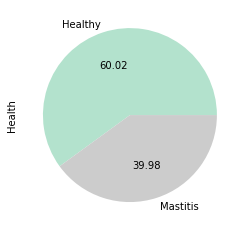

In [7]:
print(labels.value_counts())
labels.value_counts().plot.pie(autopct='%.2f', cmap =plt.cm.Pastel2)
#plt.savefig("labels_pie_chart.png")

Mastitis    3961
Healthy     3961
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


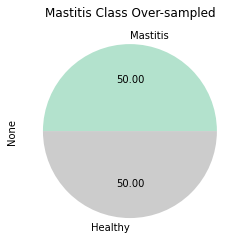

In [8]:
# Random Over sampling
ros = RandomOverSampler(sampling_strategy="not majority")
x_ros, y_ros = ros.fit_resample(feature_names, labels)

y_ros = pd.Series(y_ros)
ax = y_ros.value_counts().plot.pie(autopct='%.2f', cmap =plt.cm.Pastel2)
_ = ax.set_title("Mastitis Class Over-sampled")

print(y_ros.value_counts())
#plt.savefig("labels_ros_pie_chart.png")

## 4. Exploraing the data

### 4.1. Input features (the sensor data)

In [9]:
X = pd.DataFrame(data = x_ros[0:, 0:],
                        columns = ['Months_after_giving_birth',	'IUFL',	'EUFL',	'IUFR',	'EUFR',	'IURL',	'EURL',	'IURR',	'EURR',	'Temperature'])
  
X

,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature
0,1,150,180,150,180,150,181,150,181,43
1,1,152,180,152,185,151,180,152,181,42
2,1,152,182,153,186,151,186,153,183,41
3,1,155,183,155,189,155,182,155,186,40
4,1,150,186,150,181,150,185,150,188,41
...,...,...,...,...,...,...,...,...,...,...
7917,5,232,275,241,282,304,360,239,278,48
7918,3,241,281,236,280,306,361,241,277,43
7919,2,322,371,158,183,152,184,155,189,52
7920,4,157,185,160,194,157,189,156,188,43


In [10]:
print(X.shape)
X.values

(7922, 10)


array([[  1, 150, 180, ..., 150, 181,  43],
       [  1, 152, 180, ..., 152, 181,  42],
       [  1, 152, 182, ..., 153, 183,  41],
       ...,
       [  2, 322, 371, ..., 155, 189,  52],
       [  4, 157, 185, ..., 156, 188,  43],
       [  2, 311, 359, ..., 238, 278,  43]])

### 4.2. Output variable (the class label)

In [11]:
Y = pd.Series(data = y_ros) 
Y.columns = ["Health"]
Y

0        Healthy
1        Healthy
2        Healthy
3        Healthy
4        Healthy
          ...   
7917    Mastitis
7918    Mastitis
7919    Mastitis
7920    Mastitis
7921    Mastitis
Length: 7922, dtype: object

In [12]:
print(Y.shape)
Y.values

(7922,)


array(['Healthy', 'Healthy', 'Healthy', ..., 'Mastitis', 'Mastitis',
       'Mastitis'], dtype=object)

In [13]:
#Saving the final input
final_input = pd.concat([X, Y], axis=1, ignore_index=False)
final_input.to_csv('final_input.csv', index=False)
final_input

,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,0
0,1,150,180,150,180,150,181,150,181,43,Healthy
1,1,152,180,152,185,151,180,152,181,42,Healthy
2,1,152,182,153,186,151,186,153,183,41,Healthy
3,1,155,183,155,189,155,182,155,186,40,Healthy
4,1,150,186,150,181,150,185,150,188,41,Healthy
...,...,...,...,...,...,...,...,...,...,...,...
7917,5,232,275,241,282,304,360,239,278,48,Mastitis
7918,3,241,281,236,280,306,361,241,277,43,Mastitis
7919,2,322,371,158,183,152,184,155,189,52,Mastitis
7920,4,157,185,160,194,157,189,156,188,43,Mastitis


## 6. Build the Random Forest Model

In [14]:
########################################## CHECKPOINT ##########################################
Input = pd.read_csv("final_input.csv") 
Input

,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Health,ID
0,1,150,180,150,180,150,181,150,181,43,Healthy,Cow_001
1,1,152,180,152,185,151,180,152,181,42,Healthy,Cow_002
2,1,152,182,153,186,151,186,153,183,41,Healthy,Cow_003
3,1,155,183,155,189,155,182,155,186,40,Healthy,Cow_004
4,1,150,186,150,181,150,185,150,188,41,Healthy,Cow_005
...,...,...,...,...,...,...,...,...,...,...,...,...
7917,6,238,277,231,273,303,355,231,275,44,Mastitis,Cow_7918
7918,1,238,285,238,281,313,358,247,278,43,Mastitis,Cow_7919
7919,3,311,359,236,282,245,285,238,278,43,Mastitis,Cow_7920
7920,6,238,282,237,283,306,357,242,281,43,Mastitis,Cow_7921


In [15]:
#Encoding the the health column
encoding = {"Health":     {"Healthy": 1, "Mastitis": 0}}

In [16]:
Encoded = Input.replace(encoding)
Encoded

,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Health,ID
0,1,150,180,150,180,150,181,150,181,43,1,Cow_001
1,1,152,180,152,185,151,180,152,181,42,1,Cow_002
2,1,152,182,153,186,151,186,153,183,41,1,Cow_003
3,1,155,183,155,189,155,182,155,186,40,1,Cow_004
4,1,150,186,150,181,150,185,150,188,41,1,Cow_005
...,...,...,...,...,...,...,...,...,...,...,...,...
7917,6,238,277,231,273,303,355,231,275,44,0,Cow_7918
7918,1,238,285,238,281,313,358,247,278,43,0,Cow_7919
7919,3,311,359,236,282,245,285,238,278,43,0,Cow_7920
7920,6,238,282,237,283,306,357,242,281,43,0,Cow_7921


In [17]:
#Features
X = Encoded[Encoded.columns[:10]]
#Class labels
Y = Encoded['Health']

In [18]:
# Checks
print(X.shape)
X.head(5)

(7922, 10)


,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature
0,1,150,180,150,180,150,181,150,181,43
1,1,152,180,152,185,151,180,152,181,42
2,1,152,182,153,186,151,186,153,183,41
3,1,155,183,155,189,155,182,155,186,40
4,1,150,186,150,181,150,185,150,188,41


In [19]:
# Checks
print(Y.shape)
Y.head(5)

(7922,)


0    1
1    1
2    1
3    1
4    1
Name: Health, dtype: int64

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [21]:
X_train.shape, Y_train.shape

((6337, 10), (6337,))

In [22]:
X_test.shape, Y_test.shape

((1585, 10), (1585,))

### 6.0. Building the model with Random Forest

In [23]:
clf = RandomForestClassifier(n_estimators=100, random_state=1000, criterion='entropy')

In [24]:
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1000,
                       verbose=0, warm_start=False)

In [25]:
clf.estimators_

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=659662259, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=882709079, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth

In [26]:
figure(figsize=(60, 30), dpi=300)
tree.plot_tree(clf.estimators_[0], rounded=True, fontsize=1.5, filled=False)

#plt.savefig("decision_tree.pdf")
#plt.savefig("decision_tree.png")
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### 6.1. Performs prediction on the test set

#### *Predicted class labels*

In [27]:
print(clf.predict(X_test))

[0 0 1 ... 1 1 0]


#### *Actual class labels*

In [28]:
print(Y_test)

7317    0
132     0
1745    1
3002    1
7787    0
       ..
2418    0
989     0
3253    1
3325    1
2202    0
Name: Health, Length: 1585, dtype: int64


#### Feature Importance

In [29]:
print(clf.feature_importances_)

[0.00823522 0.13867884 0.0996604  0.10507576 0.13958853 0.12399068
 0.16346728 0.04867042 0.04993974 0.12269313]


## 10. Model Performance

In [30]:
print('Accuracy score :', clf.score(X_test, Y_test))

Accuracy score : 0.9955835962145111


[[781   0]
 [  7 797]]


<Figure size 18000x9000 with 0 Axes>

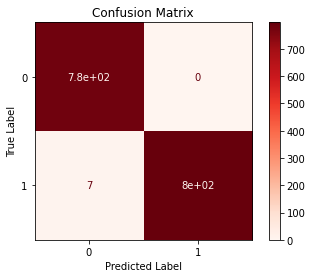

In [31]:
print(confusion_matrix(Y_test, clf.predict(X_test)))
figure(figsize=(60, 30), dpi=300)

matrix = plot_confusion_matrix(clf, X_test, Y_test, cmap=plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix', color='black')
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
#plt.gcf().set_size_inches(14,7)

#plt.savefig("confusion_matrix.pdf")
#plt.savefig("confusion_matrix.png")
plt.show()

In [32]:
# 10-fold cross-validation with K=10 for the model

#Function that will calculate the score for each test set
def get_score(clf, X_train, X_test, Y_train, Y_test):
  clf.fit(X_train, Y_train)
  return clf.score(X_test, Y_test)

kf = StratifiedKFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    scores.append(get_score(clf, X_train, X_test, Y_train, Y_test))
    
print(scores)
print(
    f"Mean Accuracy: {np.mean(scores):.3f}\nStd: {np.std(scores):.3f}\n"
)

[0.9911727616645649, 0.9911727616645649, 0.9962121212121212, 0.9962121212121212, 0.9936868686868687, 0.9987373737373737, 0.9987373737373737, 0.9974747474747475, 0.9974747474747475, 0.851010101010101]
Mean Accuracy: 0.981
Std: 0.043



## 11. Saving Outputs

In [33]:
#save the model
Model = 'RndmForest_mastistis.pkl'
with open(Model, 'wb') as file:  
    pickle.dump(clf, file)

In [ ]:
!zip RndmForest_mastistis_encoded.zip *.csv *.png *.pkl 

## 12. Loading the model

In [ ]:
#load model
with open(Model, 'rb') as file:  
    RndmForest_mastistis = pickle.load(file)
RndmForest_mastistis

score = RndmForest_mastistis.score(X_test, Y_test)
print("Test score: {0:.2f} %".format(100 * score))